In [31]:
import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
import matplotlib.pyplot as plt

In [26]:
data_dir = '/kaggle/input/cell-malaria/cell_images/cell_images'

def load_data(data_dir):
    images = []
    labels = []
    for label, sub_dir in enumerate(['Parasitized', 'Uninfected']):
        full_dir = os.path.join(data_dir, sub_dir)
        for img_file in os.listdir(full_dir):
            img_path = os.path.join(full_dir, img_file)
            try:
                img = tf.keras.preprocessing.image.load_img(img_path, target_size=(64, 64))
                img_array = tf.keras.preprocessing.image.img_to_array(img)
                images.append(img_array)
                labels.append(label)
            except UnidentifiedImageError:
                print(f"Skipping file {img_path}, as it could not be identified as an image.")
    return np.array(images), np.array(labels)

In [27]:
images, labels = load_data(data_dir)

Skipping file /kaggle/input/cell-malaria/cell_images/cell_images/Parasitized/Thumbs.db, as it could not be identified as an image.
Skipping file /kaggle/input/cell-malaria/cell_images/cell_images/Uninfected/Thumbs.db, as it could not be identified as an image.


In [40]:
dataset, info = tfds.load('malaria', with_info=True, as_supervised=True)
dataset = dataset['train']  # Get the dataset

In [41]:
def preprocess(image, label):
    image = tf.image.resize(image, (64, 64))
    image = tf.cast(image, tf.float32) / 255.0  # Normalize the image to [0, 1]
    label = tf.cast(label, tf.int32)
    return image, label

In [42]:
dataset = dataset.map(preprocess)

# Split the dataset into training and testing sets (80-20 split)
train_size = int(0.75 * info.splits['train'].num_examples)
train_dataset = dataset.take(train_size).shuffle(1000).batch(64)
test_dataset = dataset.skip(train_size).batch(64)

In [43]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
train_datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

In [44]:
model = Sequential([
    Conv2D(16, (3, 3), activation='relu', input_shape=(64, 64, 3)),
    MaxPooling2D((2, 2)),
    Conv2D(32, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(64, activation='relu'),
    Dropout(0.35),
    Dense(1, activation='sigmoid')
])

In [45]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

Epoch 1/20
323/323 ━━━━━━━━━━━━━━━━━━━━ 45s 133ms/step - accuracy: 0.5947 - loss: 0.6593 - val_accuracy: 0.8763 - val_loss: 0.3200
Epoch 2/20
323/323 ━━━━━━━━━━━━━━━━━━━━ 81s 131ms/step - accuracy: 0.9051 - loss: 0.2539 - val_accuracy: 0.9376 - val_loss: 0.1633
Epoch 3/20
323/323 ━━━━━━━━━━━━━━━━━━━━ 43s 133ms/step - accuracy: 0.9483 - loss: 0.1559 - val_accuracy: 0.9495 - val_loss: 0.1513
Epoch 4/20
323/323 ━━━━━━━━━━━━━━━━━━━━ 43s 131ms/step - accuracy: 0.9568 - loss: 0.1330 - val_accuracy: 0.9533 - val_loss: 0.1447
Epoch 5/20
323/323 ━━━━━━━━━━━━━━━━━━━━ 43s 132ms/step - accuracy: 0.9598 - loss: 0.1249 - val_accuracy: 0.9538 - val_loss: 0.1410
Epoch 6/20
323/323 ━━━━━━━━━━━━━━━━━━━━ 43s 133ms/step - accuracy: 0.9611 - loss: 0.1177 - val_accuracy: 0.9560 - val_loss: 0.1316
Epoch 7/20
323/323 ━━━━━━━━━━━━━━━━━━━━ 82s 134ms/step - accuracy: 0.9622 - loss: 0.1103 - val_accuracy: 0.9549 - val_loss: 0.1326
Epoch 8/20
323/323 ━━━━━━━━━━━━━━━━━━━━ 43s 133ms/step - accuracy: 0.9658 - loss: 0

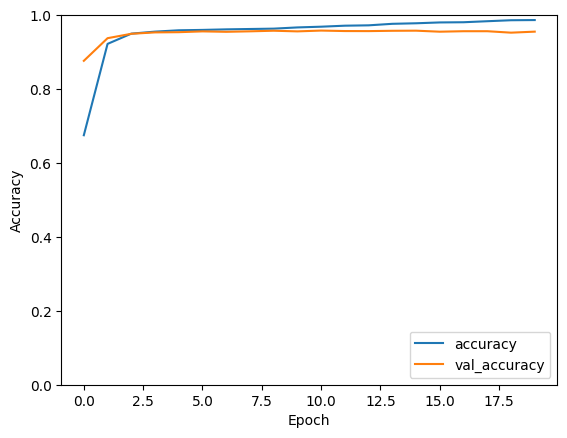

In [46]:
history = model.fit(train_dataset, epochs=20, validation_data=test_dataset)

# Evaluate the model
test_loss, test_acc = model.evaluate(test_dataset, verbose=2)
print(f'\nTest accuracy: {test_acc}')

# Plot training history
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0, 1])
plt.legend(loc='lower right')
plt.show()